<h1><center>Final Project: Robust Journey Planning</center></h1>

[1. Preprocessing](#preprocessing)
<br> $\qquad$ [1.1 Creating a Spark session](#spark_session)
<br> $\qquad$ [1.2 Metadata](#metadata)
<br> $\qquad$ [1.3 Source Data](#source_data)
<br> $\qquad$ [1.4 Distribution clusters](#clustering)
<br></br>[2. Robust Journey Planner](#planner)
<br></br> $\qquad$ [2.1 Problem statement and goal](#planner_problem)
<br></br> $\qquad$ [2.2 Echosystem](#planner_echosystem)
<br></br> $\qquad$ [2.3 Assumptions](#planner_assumptions)
<br></br> $\qquad$ [2.4 Algorithm](#planner_algorithm)
<br></br> $\qquad$ $\qquad$ [2.4.1 Differences with Dijkstra](#planner_wrt_Dijkstra)
<br></br> $\qquad$ $\qquad$ [2.4.2 Our approach](#planner_our_approach)
<br></br> $\qquad$ [2.5 Play with me!](#planner_play)
<br></br> [3. Visualization](#visualization)
<br> $\qquad$[3.1 Path](#path_vis)
<br> $\qquad$[3.2 Isochrone map](#iso_vis)
<br></br> [4. Conclusion](#conclusion)

In [1]:
import getpass
import pyspark
from pyspark.sql import SparkSession

from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pandas import Series
import datetime
import time

import pandas as pd
import numpy as np

from scipy.stats import gamma, lognorm
import matplotlib.pylab as plt
import seaborn as sns

from pyscripts.test_utils import toy_schedule
from pyscripts.planner import *
from pyscripts.metadata import *

from math import sin, cos, sqrt, atan2, radians

%matplotlib inline
%load_ext autoreload
%autoreload 2

<a id='preprocessing'></a>
# 1. Preprocessing

<a id='spark_session'></a>
## 1.1 Creating a Spark session


In [2]:
# Initialize spark session
spark = (SparkSession
         .builder
         .appName('final-proj')
         .master('yarn')
         .config('spark.port.maxRetries', 100)
         .config('spark.executor.memory', '1g')
         .config('spark.executor.instances', '2')
         .config('spark.executor.cores', '2')
         .getOrCreate())

sc = spark.sparkContext
conf = sc.getConf()

spark

<a id='metadata'></a>
## 1.2 Metadata
The metadata file contains all the stations and gps coordinates.

In [3]:
metadata = spark.read.text('/datasets/project/metadata/BFKOORD_GEO')

We save the information in a Pandas dataframe.

In [4]:
# Splitting and adding new columns to the spark dataframe
split_col = pyspark.sql.functions.split(metadata['value'], " % ")
split_left = pyspark.sql.functions.split(split_col.getItem(0), " +")
metadata = metadata.withColumn('longitude', split_left.getItem(2))
metadata = metadata.withColumn('latitude', split_left.getItem(1))
metadata = metadata.withColumn('stop', split_col.getItem(1))
metadata = metadata.drop('value')

# Save in a pandas DataFrame
metadataPandas = metadata.toPandas()
metadataPandas.head()

,longitude,latitude,stop
0,44.446770,26.074412,Bucuresti
1,50.901549,1.811446,Calais
2,51.284212,1.075329,Canterbury
3,50.729172,-3.543547,Exeter
4,46.922368,9.733756,"Fideris, Bahnhof"


We only need to keep the stations within 10km from **Zürich HB**. We can compute the distance between two stations using the GPS coordinates.

In [5]:
# Zürich HB is the starting point
zurich_coord = metadataPandas[metadataPandas['stop'] == 'Zürich HB']
zurich_coord

,longitude,latitude,stop
2379,47.378177,8.540192,Zürich HB


In [6]:
# Function to calculate the distance of gps coordinates
def compute_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6371.0 
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance*1000

In [7]:
# keep only stations inside 10km
mask = metadataPandas.apply(lambda x: compute_distance(
    float(zurich_coord['latitude']), 
    float(zurich_coord['longitude']),
    float(x['latitude']), 
    float(x['longitude'])) <= 10000, axis=1)
metadataPandas = metadataPandas[mask]

<a id='source_data'></a>
## 1.3 Source Data
Open Data Platform Swiss Public Transport (https://opentransportdata.swiss).

The source data is used to construct a schedule for the area of Zurich that will be used by the Planner. The final schedule contains the edges (i.e. couples of start_station, arrival_station) along with the id of the trip they belong to, the departure/arrival times and other useful information.

In [8]:
# Directory with the source data
df = spark.read.option("delimiter", ";").option("header", "true").csv('/datasets/project/istdaten/*/*')

We select and rename only the information that will be used.

In [9]:
# Keep only the needed information and rename
df = df.select(
          df['BETRIEBSTAG'].alias('date'), 
          df['FAHRT_BEZEICHNER'].alias('id'), 
          df['PRODUKT_ID'].alias('transport_type'), 
          df['LINIEN_ID'].alias('train_number'), 
          df['HALTESTELLEN_NAME'].alias('stop_name'), 
          df['ANKUNFTSZEIT'].alias('arrival_time'), 
          df['AN_PROGNOSE'].alias('actual_arrival_time'),
          df['AN_PROGNOSE_STATUS'].alias('status_arrival_time'),
          df['ABFAHRTSZEIT'].alias('departure_time'),
          df['AB_PROGNOSE'].alias('actual_departure_time'),
          df['AB_PROGNOSE_STATUS'].alias('status_departure_time'),
          df['DURCHFAHRT_TF'].alias('stop_here'))

We first filter the unnecessary row and compute the arrival and departure delays.

In [10]:
# compute the departure and arrival delays
formatTS1 = "dd.MM.yyyy HH:mm:ss"
formatTS2 = "dd.MM.yyyy HH:mm"

departure_delay = (F.unix_timestamp('actual_departure_time', formatTS1) - 
        F.unix_timestamp('departure_time', formatTS2))
arrival_delay = (F.unix_timestamp('actual_arrival_time', formatTS1) - 
        F.unix_timestamp('arrival_time', formatTS2))

# extract the day of the week
def get_week_day(date):
    converted_date = datetime.datetime.strptime(str(date), "%d.%m.%Y")
    return converted_date.weekday()

week_day_udf = F.udf(get_week_day, IntegerType())

# udf to fill NaN departure (arrival) values with the arrival (departure) time
@udf('string')
def fillWithOther(a, b):
    if (a is None):
        return b
    return a
    
# date parser
date = F.to_date('date', 'dd.MM.yyyy')

# First filtering. arrival_delay and departure_delay columns
df_filtered = (df.filter((df.status_arrival_time == 'GESCHAETZT') | (df.status_departure_time == 'GESCHAETZT'))
     .withColumn("arrival_delay", arrival_delay)
     .withColumn("departure_delay", departure_delay)
                      )

# Handling the NaN values
df_with_delays = df_filtered.select('id', 'train_number', 'stop_name', 'arrival_time', 'arrival_delay', 'departure_time', 'departure_delay', 'date')
df_with_delays = df_with_delays.fillna(0, ['departure_delay', 'arrival_delay'])
df_with_delays = (df_with_delays
                  .withColumn('arrival_time2', fillWithOther(df_with_delays.arrival_time, df_with_delays.departure_time))
                  .withColumn('departure_time2', fillWithOther(df_with_delays.departure_time, df_with_delays.arrival_time))
                  .drop(df_with_delays.departure_time).drop(df_with_delays.arrival_time)
                 )
df_with_delays = df_with_delays.withColumnRenamed('departure_time2', 'departure_time').withColumnRenamed('arrival_time2', 'arrival_time')
# Adding the day of the week and the week day of the start of the trip
df_with_delays = df_with_delays.withColumn("day_week_start", week_day_udf(df_with_delays.date))
df_with_delays = df_with_delays.withColumn("day_week", week_day_udf(F.split(df_with_delays.arrival_time, " ")[0]))

# Filtering outliers
df_with_delays = df_with_delays.filter((df_with_delays['arrival_delay'] > -1000) &
                                       (df_with_delays['arrival_delay'] < 1000) &
                                       (df_with_delays['departure_delay'] > -1000) &
                                       (df_with_delays['departure_delay'] < 1000)
                                      )

For each trip id, we need to collect the list of stations. We do it in the following steps:
- Filter the stops that are not in the metadata (i.e. outside 10km).
- Add a new column 'info' containing all the needed information to collect (stop name, arrival time, arrival delay, departure time, departure delay, day of the week).
- Group by trip id.
- Collect the list of the 'info' rows in the group.

In [11]:
df_grouped = (df_with_delays
    .filter(df_with_delays.stop_name.isin(metadataPandas.stop.tolist()))
    .withColumn('info', F.struct('stop_name', F.split('arrival_time', " ")[1], 'arrival_delay', F.split('departure_time', " ")[1], 'departure_delay', 'day_week', 'day_week_start'))
    .groupby('id')
    .agg(F.collect_list('info').alias('info'))
              )

In [12]:
# Collecting the groups
groups = df_grouped.collect()

For each group we collected, we have to compute:
- mean, standard deviation and list of delays for both arrival and departure time
- computing the list of (start_station, arrival_station) couples for each trip (they will be referred as edges)
- discard couples that are incorrect

In [13]:
# Function to compute the delta between departur and arrival time. If the delta is too high, it will be filtered
def compute_delta(arrival, departure, day):
    d1 = datetime.datetime.strptime(arrival, "%H:%M")
    d2 = datetime.datetime.strptime(departure, "%H:%M")
    d1_ts = time.mktime(d1.timetuple())
    d2_ts = time.mktime(d2.timetuple())
    res = int(d2_ts-d1_ts) / 60
    if (day > 0):
        res = res + 60 * 24 * day
    return res

def delays(s):
    return tuple(s)

# DataFrame containing the final schedule
schedule = pd.DataFrame(columns= ['trip_id', 'dep_node', 'arr_node', 
                                  'dep_time', 'arr_time',
                                  'mean_delay', 'std_delay', 
                                  'dep_day', 'arr_day', 'day_start',
                                  'delta', 'delays'])

# Iterating through groups
for group in groups:
    trip_id = group[0]
    info = group[1]
    p = pd.DataFrame(info, columns=['stop', 'arrival_time', 'arrival_delay','departure_time', 'departure_delay', 'week_day', 'day_week_start'])

    # Computing the mean of arrival and departure delays
    c = p.groupby(['week_day', 'arrival_time', 'departure_time', 'stop']).agg([np.mean, np.std, delays])

    c = c.reset_index()
    c.columns = [' '.join(col).strip() for col in c.columns.values]
    
    
    # Creating all the couples of (start_station, arrival_station) for each trip. The order of the schedule 
    # is manteined by the groupby operation. We can have the same trip for different days of the week, 
    # or the trip can even change on different days. The compute_delta function calculates the time interval
    # between each couple: if the interval is too high, it means that a new trip started and the couple has to be
    # discarded. We also consider trips that are scheduled between midnight (in this case the week_day changes).
    # Example: trip_id composed by stations [A, B, C, A, B, C, A, B, D]. The list is composed by 3 trips. We create
    # the couples [(A, B), (B, C), (C, A), (A, B), (B, C), (C, A), (A, B), (B, D)]. Obviously, the couples 
    # (C, A) and (C, A) are not correct, because the C is the last station of a trip and A is the first one of
    # a new trip. They can be easily discarded because the time interval between the two is too high. This is based
    # on the fact that there is no more than one trip per day (so the 3 trips happen in different days).
    partialResult = pd.DataFrame([(trip_id,
                        c.loc[i, 'stop'], 
                        c.loc[i+1, 'stop'], 
                        c.loc[i, 'departure_time'], 
                        c.loc[i+1, 'arrival_time'], 
                        c.loc[i+1, 'arrival_delay mean'],
                        c.loc[i+1, 'arrival_delay std'], 
                        c.loc[i, 'week_day'], 
                        c.loc[i+1, 'week_day'], 
                        c.loc[i, 'day_week_start mean'],
                        compute_delta(c.loc[i, 'departure_time'], 
                                      c.loc[i+1, 'arrival_time'], 
                                      c.loc[i+1, 'week_day']-c.loc[i, 'week_day']),
                        c.loc[i+1, 'arrival_delay delays']) 
                                  for i in range(len(c)-1)],
                     columns = ['trip_id', 'dep_node', 'arr_node', 
                               'dep_time', 'arr_time',
                               'mean_delay', 'std_delay', 
                               'dep_day', 'arr_day', 'day_start', 
                               'delta', 'delays'])
    # Need to merge the last station with the first, in case of a trip that starts on sunday night and finisches
    # on monday morning
    m = len(c)-1
    partialResult = partialResult.append([{'trip_id': trip_id,
                'dep_node': c.loc[m, 'stop'], 
                'arr_node': c.loc[0, 'stop'], 
                'dep_time': c.loc[m, 'departure_time'], 
                'arr_time': c.loc[0, 'arrival_time'],
                'mean_delay': c.loc[m, 'arrival_delay mean'], 
                'std_delay': c.loc[m, 'arrival_delay std'], 
                'dep_day': c.loc[m, 'week_day'], 
                'arr_day': c.loc[0, 'week_day'],
                'day_start': c.loc[m, 'day_week_start mean'],
                'delta': compute_delta(c.loc[m, 'departure_time'], c.loc[0, 'arrival_time'], c.loc[0, 'week_day']+7-c.loc[m, 'week_day']),
                'delays': c.loc[m, 'arrival_delay delays']
                 }], ignore_index=True
               )
    # Filtering the wrong couples and couples where the start and stop stations are the same
    partialResult = partialResult[partialResult.delta < 180]
    partialResult = partialResult[partialResult.dep_node != partialResult.arr_node]
    schedule = schedule.append(partialResult)

schedule.reset_index(drop=True, inplace=True)
schedule.head()

,trip_id,dep_node,arr_node,dep_time,arr_time,mean_delay,std_delay,dep_day,arr_day,day_start,delta,delays
0,85:11:18388:001,Dietlikon,Stettbach,23:14,23:17,60.151515,105.014023,0,0,0,3.0,"(62, 346, -71, 70, -5, 75, 1, -20, -5, 34, -2,..."
1,85:11:18388:001,Stettbach,Zürich Stadelhofen,23:18,23:22,67.666667,97.935459,0,0,0,4.0,"(13, 406, -1, 37, -1, 44, 9, 13, 12, 148, 0, 3..."
2,85:11:18388:001,Zürich Stadelhofen,Zürich HB,23:23,23:26,14.606061,92.191695,0,0,0,3.0,"(-46, 354, -46, -25, -40, -9, -23, -17, -44, 1..."
3,85:11:18388:001,Zürich HB,Zürich Hardbrücke,23:29,23:31,40.606061,38.486150,0,0,0,2.0,"(36, 234, 19, 43, 29, 52, 37, 23, 17, 36, 38, ..."
4,85:11:18388:001,Zürich Hardbrücke,Zürich Altstetten,23:31,23:35,3.545455,40.070322,0,0,0,4.0,"(-17, 174, -34, 1, -22, 26, 7, -15, -23, -21, ..."


Dealing with **errors**.

We found some wrong trips, always between Zurich HB and Zurich Oerlikon. We suppose that these are errors, because in other days the same trip doesn't include Zurich Oerlikon.

In [14]:
schedule[(schedule['dep_time'] > schedule['arr_time']) & (schedule['dep_day'] == schedule['arr_day'])].head()

,trip_id,dep_node,arr_node,dep_time,arr_time,mean_delay,std_delay,dep_day,arr_day,day_start,delta,delays
1307,85:11:19256:001,Zürich HB,Zürich Oerlikon,15:14,15:12,-66.0,NaN,0,0,0,-2.0,"(-66,)"
4008,85:11:19254:001,Zürich HB,Zürich Oerlikon,14:44,14:42,-139.0,NaN,0,0,0,-2.0,"(-139,)"
15175,85:11:19253:001,Zürich HB,Zürich Oerlikon,14:17,14:16,54.0,NaN,0,0,0,-1.0,"(54,)"
15301,85:11:19285:001,Zürich HB,Zürich Oerlikon,22:17,22:16,156.0,NaN,3,3,3,-1.0,"(156,)"
19164,85:11:19247:001,Zürich HB,Zürich Oerlikon,12:47,12:46,94.0,NaN,0,0,0,-1.0,"(94,)"


In [15]:
# These are the trips that have to be modified
trip_id_to_modify = schedule[(schedule['dep_time'] > schedule['arr_time']) & (schedule['dep_day'] == schedule['arr_day'])]['trip_id']

# Modifying the wrong rows
for i, row in schedule.iterrows():
    if ((schedule.loc[i, 'trip_id'] in list(trip_id_to_modify.values)) &
       (schedule.loc[i, 'arr_node'] == 'Zürich Oerlikon')):
        schedule.loc[i, 'arr_node'] = schedule.loc[i+1, 'arr_node']
        schedule.loc[i, 'arr_time'] = schedule.loc[i+1, 'arr_time']
        schedule.loc[i, 'mean_delay'] = schedule.loc[i+1, 'mean_delay']
        schedule.loc[i, 'std_delay'] = schedule.loc[i+1, 'std_delay']
        
# Eliminating the wrong rows
schedule = schedule[ (~schedule['trip_id'].isin(list(trip_id_to_modify.values)))
        | ((schedule['trip_id'].isin(list(trip_id_to_modify.values)))
           & (schedule['dep_node'] != 'Zürich Oerlikon'  ) )]

In [16]:
# change time type and drop columns
schedule = (schedule.drop(['delta'], axis=1))

def make_time(entry):
    return pd.Timedelta(entry+':00')

schedule['dep_time'] = schedule['dep_time'].apply(lambda x: make_time(x))
schedule['arr_time'] = schedule['arr_time'].apply(lambda x: make_time(x))
          
schedule.head()

,trip_id,dep_node,arr_node,dep_time,arr_time,mean_delay,std_delay,dep_day,arr_day,day_start,delays
0,85:11:18388:001,Dietlikon,Stettbach,23:14:00,23:17:00,60.151515,105.014023,0,0,0,"(62, 346, -71, 70, -5, 75, 1, -20, -5, 34, -2,..."
1,85:11:18388:001,Stettbach,Zürich Stadelhofen,23:18:00,23:22:00,67.666667,97.935459,0,0,0,"(13, 406, -1, 37, -1, 44, 9, 13, 12, 148, 0, 3..."
2,85:11:18388:001,Zürich Stadelhofen,Zürich HB,23:23:00,23:26:00,14.606061,92.191695,0,0,0,"(-46, 354, -46, -25, -40, -9, -23, -17, -44, 1..."
3,85:11:18388:001,Zürich HB,Zürich Hardbrücke,23:29:00,23:31:00,40.606061,38.486150,0,0,0,"(36, 234, 19, 43, 29, 52, 37, 23, 17, 36, 38, ..."
4,85:11:18388:001,Zürich Hardbrücke,Zürich Altstetten,23:31:00,23:35:00,3.545455,40.070322,0,0,0,"(-17, 174, -34, 1, -22, 26, 7, -15, -23, -21, ..."


Drop edges with **few delays**:

Many edges happened **only few times** (we can see it  from the collected number of delays). To build our schedule we drop all the trips that happened **less times than a treshold** because if a trip took place 10 times over 33 weeks then it is reasonable to not consider it in the schedule. Notice that our schedule has been computed **week-wise** because we want to extract a schedule for each day of the week. Therefore, we won't have a different schedule for special days like Easter or Christmas.

In [17]:
# check how many delays per edge we have 
# add column with the number of delays per edge
schedule.loc[~schedule.delays.isnull(), "num_delays"] = schedule.delays.loc[~schedule.delays.isnull()].apply(lambda x: np.NaN if x == np.NaN else len(x))
print("Number of delays per bus/metro/train edge:\n", schedule.num_delays.describe())

Number of delays per bus/metro/train edge:
 count    98409.000000
mean        20.071670
std         11.553257
min          1.000000
25%         12.000000
50%         20.000000
75%         32.000000
max         33.000000
Name: num_delays, dtype: float64


In [18]:
# and keep into the schedule only trips happened more than treshold times
treshold = 20
schedule = schedule[schedule.num_delays >= treshold]
schedule.head()

,trip_id,dep_node,arr_node,dep_time,arr_time,mean_delay,std_delay,dep_day,arr_day,day_start,delays,num_delays
0,85:11:18388:001,Dietlikon,Stettbach,23:14:00,23:17:00,60.151515,105.014023,0,0,0,"(62, 346, -71, 70, -5, 75, 1, -20, -5, 34, -2,...",33
1,85:11:18388:001,Stettbach,Zürich Stadelhofen,23:18:00,23:22:00,67.666667,97.935459,0,0,0,"(13, 406, -1, 37, -1, 44, 9, 13, 12, 148, 0, 3...",33
2,85:11:18388:001,Zürich Stadelhofen,Zürich HB,23:23:00,23:26:00,14.606061,92.191695,0,0,0,"(-46, 354, -46, -25, -40, -9, -23, -17, -44, 1...",33
3,85:11:18388:001,Zürich HB,Zürich Hardbrücke,23:29:00,23:31:00,40.606061,38.486150,0,0,0,"(36, 234, 19, 43, 29, 52, 37, 23, 17, 36, 38, ...",33
4,85:11:18388:001,Zürich Hardbrücke,Zürich Altstetten,23:31:00,23:35:00,3.545455,40.070322,0,0,0,"(-17, 174, -34, 1, -22, 26, 7, -15, -23, -21, ...",33


Estract the **paths** of the trips and add a column indicating the id of the path. The path is relative to a trip in a certain day of the week.

In [24]:
# Function to extract the list of station of the path
def extract_path(x):
    x.dep_node = list(x.dep_node)
    x.arr_node = list(x.arr_node)
    v = x.dep_node
    v.append(x.arr_node[-1])

    return v

# collect the path of each trip_id
paths = (schedule
         .sort_values(["dep_day", "dep_time"])
         .groupby(["trip_id", "day_start"])[["dep_node", "arr_node"]]
         .agg(lambda x: tuple(x))
        )

paths.reset_index(inplace=True)
paths['path'] = paths.apply(func = extract_path, axis=1)
paths.drop(["dep_node", "arr_node"], axis=1, inplace=True)

paths.path = paths.path.astype("str")

paths["path_id"] = pd.factorize(paths.path)[0]
paths.set_index("trip_id", inplace=True)

# join the new information to the schedule
schedule = schedule.merge(paths.reset_index()[["trip_id", "day_start", "path_id"]], how="left")

In [25]:
schedule.head()

,trip_id,dep_node,arr_node,dep_time,arr_time,mean_delay,std_delay,dep_day,arr_day,day_start,delays,num_delays,path_id
0,85:11:18388:001,Dietlikon,Stettbach,23:14:00,23:17:00,60.151515,105.014023,0,0,0,"(62, 346, -71, 70, -5, 75, 1, -20, -5, 34, -2,...",33,2
1,85:11:18388:001,Stettbach,Zürich Stadelhofen,23:18:00,23:22:00,67.666667,97.935459,0,0,0,"(13, 406, -1, 37, -1, 44, 9, 13, 12, 148, 0, 3...",33,2
2,85:11:18388:001,Zürich Stadelhofen,Zürich HB,23:23:00,23:26:00,14.606061,92.191695,0,0,0,"(-46, 354, -46, -25, -40, -9, -23, -17, -44, 1...",33,2
3,85:11:18388:001,Zürich HB,Zürich Hardbrücke,23:29:00,23:31:00,40.606061,38.486150,0,0,0,"(36, 234, 19, 43, 29, 52, 37, 23, 17, 36, 38, ...",33,2
4,85:11:18388:001,Zürich Hardbrücke,Zürich Altstetten,23:31:00,23:35:00,3.545455,40.070322,0,0,0,"(-17, 174, -34, 1, -22, 26, 7, -15, -23, -21, ...",33,2


In [26]:
# Save the trip paths
paths.to_pickle("data/trip_paths.pkl")

We consider the **walking time** between each station. It can happen that two stations are not connected by any vehicle or that the algorithm choose that is faster to walk instead of waiting for a vehicle.

In [27]:
# Filtering the metadata with the stations we have in the dataset
node_set = list(set(schedule['dep_node']) | set(schedule['arr_node']))
metadata_filtered = metadataPandas[metadataPandas['stop'].isin(node_set)]

In [28]:
# Compute the walking times between stations. Keeping only stations within 500m
walk = pd.DataFrame(columns= ['trip_id', 'dep_node', 'arr_node', 
                              'dep_time', 'arr_time',
                              'mean_delay', 'std_delay', 
                              'dep_day', 'arr_day', 'day_start', 'delays', 'num_delays', 'path_id'])
for _, stop1 in metadata_filtered.iterrows():
    for _, stop2 in metadata_filtered.iterrows():
        if (stop1.stop != stop2.stop):
            distance = compute_distance(float(stop1.latitude), float(stop1.longitude), 
                                       float(stop2.latitude), float(stop2.longitude))
            if (distance <= 500):
                walk = walk.append({'trip_id': '0000', 
                                    'dep_node': stop1.stop, 
                                    'arr_node': stop2.stop, 
                                    'mean_delay': distance, # considering 1m/s of walking speed
                                    'std_delay': 0.0}, ignore_index=True)

walk.head()

,trip_id,dep_node,arr_node,dep_time,arr_time,mean_delay,std_delay,dep_day,arr_day,day_start,delays,num_delays,path_id
0,0000,Zürich HB,Zürich HB SZU,NaN,NaN,140.155394,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0000,Zürich Binz,Zürich Giesshübel,NaN,NaN,381.334098,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0000,Zürich HB SZU,Zürich HB,NaN,NaN,140.155394,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0000,Zürich Giesshübel,Zürich Binz,NaN,NaN,381.334098,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0000,Zürich Manegg,Zürich Leimbach,NaN,NaN,415.434743,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
schedule = schedule.append(walk)

We also compute the distance between each couple of stations and save it in a file. It will be used later in the planner algorithm.

In [30]:
distanceMatrix = metadata_filtered.copy()
for _, i in distanceMatrix.iterrows():
    for _, j in distanceMatrix.iterrows():
        distance = compute_distance(float(i.latitude), float(i.longitude), float(j.latitude), float(j.longitude))
        distanceMatrix.loc[distanceMatrix.stop == i.stop, j.stop] = distance

distanceMatrix = distanceMatrix.drop(["latitude", "longitude"], axis=1).set_index('stop')

In [31]:
distanceMatrix.head()

,Bonstetten-Wettswil,Zürich HB,Zürich Altstetten,Zürich Stadelhofen,Zürich Tiefenbrunnen,Zürich Oerlikon,Zürich Seebach,Zürich Affoltern,Zürich Wollishofen,Zürich Enge,...,Kilchberg,Rüschlikon,Thalwil,Dietlikon,Kloten,Kloten Balsberg,Glattbrugg,Rümlang,Opfikon,Regensdorf-Watt
stop,,,,,,,,,,,,,,,,,,,,,
Bonstetten-Wettswil,0.000000,9858.153857,7573.568223,9987.798035,10700.053799,12648.614390,13287.190924,11373.926812,7649.743793,8133.286627,...,8877.491824,9888.950775,11231.968842,19741.781068,18637.776623,17140.303799,15322.195222,15818.681535,15467.729505,12179.068932
Zürich HB,9858.153857,0.000000,5883.760357,1569.694663,3880.950233,3693.284968,4488.416505,5869.684660,3458.782377,1867.081350,...,5973.699200,7987.109233,9442.450845,9931.379243,9136.575181,7823.200251,6149.094184,8386.080050,6178.028837,9930.500980
Zürich Altstetten,7573.568223,5883.760357,0.000000,7161.755510,9249.391411,6519.274172,6880.776814,3903.660052,6935.717090,5544.194590,...,9874.094756,11842.255847,13467.342901,14830.356759,12275.989954,10670.845149,8894.837135,8431.839555,9136.647151,5301.310988
Zürich Stadelhofen,9987.798035,1569.694663,7161.755510,0.000000,2312.135184,4962.832411,5748.679426,7439.218882,2679.717917,1983.144992,...,4638.719488,6582.227641,7975.337410,9832.022890,9834.431195,8680.604675,7154.421660,9774.413892,7120.179940,11460.839077
Zürich Tiefenbrunnen,10700.053799,3880.950233,9249.391411,2312.135184,0.000000,7019.370389,7771.761171,9750.524035,3103.504734,3730.136866,...,3192.884568,4777.496551,5965.845849,10038.901409,11111.817701,10186.694367,8878.182474,11864.558991,8777.664268,13746.742839


In [32]:
# Checkpoint, save raw schedule and distance matrix in a file
schedule.to_pickle("data/schedule_raw.pkl")
distanceMatrix.to_pickle('data/pairwise_distance.pkl')

In [33]:
schedule = pd.read_pickle("data/schedule_raw.pkl")

schedule.reset_index(drop=True, inplace=True)

# put the walking time in the arrival time
schedule.loc[schedule.trip_id=="0000", "walking_time"] = schedule.loc[schedule.trip_id == "0000", "mean_delay"].apply(lambda secs: pd.Timedelta("00:00:"+str(secs)))

# sort columns and drop mean_delay and std_delay
schedule = schedule[["trip_id", "path_id", "dep_node", "arr_node", "dep_day", "arr_day", "dep_time", "arr_time", "delays", "num_delays", "walking_time"]].copy()

schedule.head()

,trip_id,path_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,delays,num_delays,walking_time
0,85:11:18388:001,2.0,Dietlikon,Stettbach,0,0,23:14:00,23:17:00,"(62, 346, -71, 70, -5, 75, 1, -20, -5, 34, -2,...",33.0,NaT
1,85:11:18388:001,2.0,Stettbach,Zürich Stadelhofen,0,0,23:18:00,23:22:00,"(13, 406, -1, 37, -1, 44, 9, 13, 12, 148, 0, 3...",33.0,NaT
2,85:11:18388:001,2.0,Zürich Stadelhofen,Zürich HB,0,0,23:23:00,23:26:00,"(-46, 354, -46, -25, -40, -9, -23, -17, -44, 1...",33.0,NaT
3,85:11:18388:001,2.0,Zürich HB,Zürich Hardbrücke,0,0,23:29:00,23:31:00,"(36, 234, 19, 43, 29, 52, 37, 23, 17, 36, 38, ...",33.0,NaT
4,85:11:18388:001,2.0,Zürich Hardbrücke,Zürich Altstetten,0,0,23:31:00,23:35:00,"(-17, 174, -34, 1, -22, 26, 7, -15, -23, -21, ...",33.0,NaT


In [34]:
# separate bus/metro/train edges from walking edges
no_walk = schedule[(schedule.trip_id != "0000")]
walk = schedule[(schedule.trip_id == "0000")]

<a id='clustering'></a>
## 1.4 Distribution clusters

**Clusterize** all the edges depending on their delays. Edges with similar delays will be associated with the same cluster and each cluster will be associated to a **gamma distribution** initialized with the mean and standart deviation of the delays of the whole cluster. 

We use KMeans to clusterize the edges, however, each edge has between 20 to 33 unordered delays so we extracted the `[20, 30, 40, 50, 60, 70, 80]` qth percentiles for each edge and used them as the features of that edge. This allows to represent more meaningfully the delay distribution of each edge while also dropping some possible outliers.

Note that we take in account only the arrival delays. The reason is that we want to consider only the connections whose scheduled departure follows our arrival. Moreover, the departure delay is never negative (as we can notice in the below picture), because the transport does not leave a station before the scheduled time. Therefore, it does not make senso to build a random variable for the departure delays.

![alt text](img/delay_distributions.png)

In [35]:
percentiles = [20, 30, 40, 50, 60, 70, 80]
X = pd.DataFrame(
    columns=percentiles,
)
for p in percentiles:
    X[p] = no_walk.delays.apply(lambda delays: np.percentile(delays, p))
    
X.head()

,20,30,40,50,60,70,80
0,-7.6,-4.4,-2.0,21.0,44.2,72.0,110.6
1,5.0,12.0,13.8,22.0,44.6,59.4,108.8
2,-42.8,-39.4,-37.2,-23.0,-15.4,-2.4,65.2
3,20.4,24.0,29.8,36.0,37.2,41.2,45.8
4,-21.6,-18.2,-16.0,-7.0,3.0,7.4,16.8


Now that we have the features we can run the **KMeans**. Note that the index is the same as the initial dataframe, i.e. we obviously know which percentiles belong to which edge, therefore we can proceed in the clustering. We run KMeans for several number of clusters and plot their respective inertia, i.e. the **within-cluster sum-of-squares**. Then we use the elbow method to choose the more reasonable number of clusters.

Fitting on K=10...
Fitting on K=50...
Fitting on K=100...
Fitting on K=200...
Fitting on K=300...
Fitting on K=500...
Fitting on K=800...


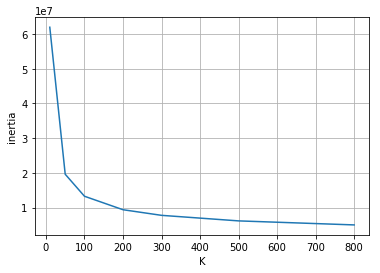

In [36]:
from sklearn.cluster import KMeans

n_clusters = [10, 50, 100, 200, 300, 500, 800]

kmeans = {}
for n_cluster in n_clusters:
    print("Fitting on K="+str(n_cluster) + "...")
    model = KMeans(n_cluster, random_state=0, n_jobs=10)
    kmeans[n_cluster] = model
    
    model.fit(X)

plt.grid()
plt.ylabel("inertia")
plt.xlabel("K")
plt.plot(n_clusters, [model.inertia_ for _, model in kmeans.items()])

In [37]:
# choose the best K and get the corresponding labels
K = 200
X['labels'] = kmeans[K].labels_
X.head()

,20,30,40,50,60,70,80,labels
0,-7.6,-4.4,-2.0,21.0,44.2,72.0,110.6,158
1,5.0,12.0,13.8,22.0,44.6,59.4,108.8,158
2,-42.8,-39.4,-37.2,-23.0,-15.4,-2.4,65.2,95
3,20.4,24.0,29.8,36.0,37.2,41.2,45.8,76
4,-21.6,-18.2,-16.0,-7.0,3.0,7.4,16.8,117


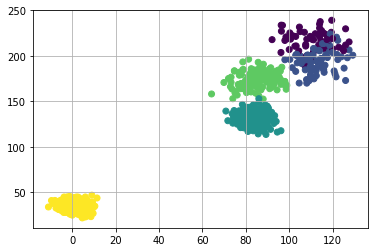

In [38]:
# plot a random subset of the clusters and use only the two percentiles 30 and 70 as dimensions
num_clusters_to_plt = 5
clusters = np.random.choice(K, num_clusters_to_plt, replace=False)
cluster_mapping = dict(zip(clusters, range(num_clusters_to_plt)))

small = X[X['labels'].isin(clusters)].copy()
small['labels'] = small['labels'].apply(lambda label: cluster_mapping[label]) # map the labels to an integer in [0, 1, ..., num_clusters_to_plt-1] so the color is automatically chosen well

plt.grid()
plt.scatter(small[30], small[70], c=small['labels'])

In [39]:
# Adding the cluster label to the schedule
schedule = pd.concat([no_walk, walk], axis=0)
schedule.loc[X.index, "label"] = X["labels"]

schedule.head()

,trip_id,path_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,delays,num_delays,walking_time,label
0,85:11:18388:001,2.0,Dietlikon,Stettbach,0,0,23:14:00,23:17:00,"(62, 346, -71, 70, -5, 75, 1, -20, -5, 34, -2,...",33.0,NaT,158.0
1,85:11:18388:001,2.0,Stettbach,Zürich Stadelhofen,0,0,23:18:00,23:22:00,"(13, 406, -1, 37, -1, 44, 9, 13, 12, 148, 0, 3...",33.0,NaT,158.0
2,85:11:18388:001,2.0,Zürich Stadelhofen,Zürich HB,0,0,23:23:00,23:26:00,"(-46, 354, -46, -25, -40, -9, -23, -17, -44, 1...",33.0,NaT,95.0
3,85:11:18388:001,2.0,Zürich HB,Zürich Hardbrücke,0,0,23:29:00,23:31:00,"(36, 234, 19, 43, 29, 52, 37, 23, 17, 36, 38, ...",33.0,NaT,76.0
4,85:11:18388:001,2.0,Zürich Hardbrücke,Zürich Altstetten,0,0,23:31:00,23:35:00,"(-17, 174, -34, 1, -22, 26, 7, -15, -23, -21, ...",33.0,NaT,117.0


In [40]:
# Checkpoint
schedule.to_pickle("data/schedule_clustered.pkl")

### Fit a distribution to each cluster

We now create a **distribution** for each cluster and store them in the schedule.
Why?

- We have few samples per edge which may not be representative enough of its delay distribution.
- It is reasonable that some edges' delays are dependent. The clusters have hopefully grouped edges whose delays are jointly dependent.

In [41]:
schedule = pd.read_pickle("data/schedule_clustered.pkl")
schedule.head(1)

,trip_id,path_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,delays,num_delays,walking_time,label
0,85:11:18388:001,2.0,Dietlikon,Stettbach,0,0,23:14:00,23:17:00,"(62, 346, -71, 70, -5, 75, 1, -20, -5, 34, -2,...",33.0,NaT,158.0


- collect **all the delays** for each cluster

In [42]:
# get the labels of the clusters
clusters_labels = sorted(schedule["label"].dropna().astype(int).unique())

# collect all the delays for each cluster
cluster_delays = {} # map cluster -> list fo delays
for c_id in clusters_labels:
    cluster = schedule[schedule["label"] == c_id]
    cluster_delays[c_id] = np.array([delay for edge_delays in cluster.delays for delay in edge_delays])

- **fit a gamma** for each cluster and plot corresponding distributions and histograms

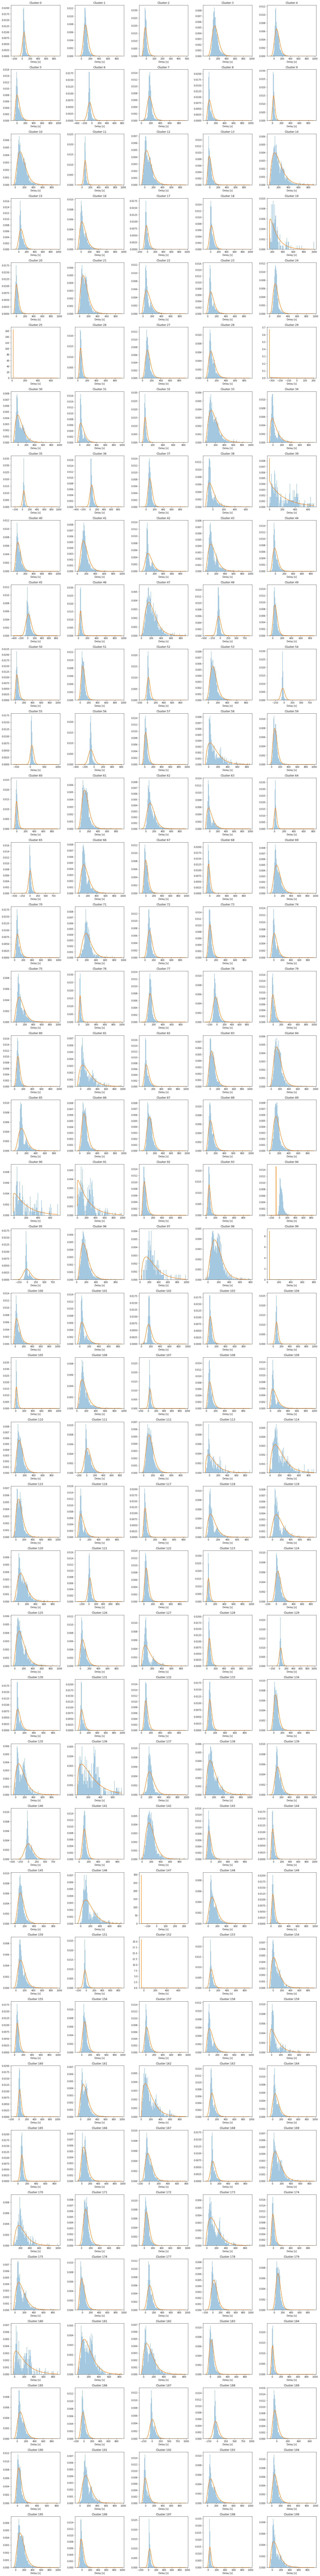

In [43]:
gammas = {} # map cluster label -> gamma distribution

ncols = 5
nrows = 40
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))

axs = np.ndenumerate(axs)

for cl, delays in cluster_delays.items():
    
    _, ax = next(axs)
    
    sns.set(color_codes=True)

    # plot histogram
    ax.set(xlabel='Delay [s]')
    sns.distplot(delays, bins=100, kde=False, ax=ax, norm_hist=True)
    
    # fit the gamma on the delays of the cluster
    if cl in [70, 94]:
        # these two clusters are best fitted in this way
        gammas[cl] = gamma(
            *gamma.fit(
                delays,
                loc=delays.min()
            )
        )
    else:
        gammas[cl] = gamma(
            *gamma.fit(
                delays,
                floc=delays.min()-1e-10)
        )

    # plot the gamma's pdf on the same plot
    x = np.linspace(delays.min(),delays.max(),1000)
    ax.plot(x, gammas[cl].pdf(x), label='Gamma distribution')
    ax.set_title("Cluster:" + str(cl))
    
plt.tight_layout()

We can see that the **gammas fit reasonibly well** the delays of the clusters! Let's see the probabilities of the delays being **lower than 5 minutes** (300 seconds):

In [44]:
pd.Series([gamma.cdf(300) for _, gamma in gammas.items()]).describe()

count    200.000000
mean       0.953308
std        0.081138
min        0.627413
25%        0.946573
50%        0.995058
75%        0.999912
max        1.000000
dtype: float64

Most of the probabilities are high, it means that there is often a high probability that the transports do less than 5 minutes of delay and we can safely take a connection whose departure is scheduled 5 minutes after our arrival. 

- add a new column to the `schedule` to **store**, for each edge, **the distribution** of its cluster. Then, store the obtained `schedule`.

In [45]:
for c_id in clusters_labels:
    schedule.loc[schedule["label"] == c_id, "distribution"] = gammas[c_id]
schedule.head(2)

,trip_id,path_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,delays,num_delays,walking_time,label,distribution
0,85:11:18388:001,2.0,Dietlikon,Stettbach,0,0,23:14:00,23:17:00,"(62, 346, -71, 70, -5, 75, 1, -20, -5, 34, -2,...",33.0,NaT,158.0,<scipy.stats._distn_infrastructure.rv_frozen o...
1,85:11:18388:001,2.0,Stettbach,Zürich Stadelhofen,0,0,23:18:00,23:22:00,"(13, 406, -1, 37, -1, 44, 9, 13, 12, 148, 0, 3...",33.0,NaT,158.0,<scipy.stats._distn_infrastructure.rv_frozen o...


In [46]:
# Checkpoint
schedule.to_pickle("data/schedule_clustered.pkl")

### Final clean 
Add/remove the columns to obtain the final DataFrame that will be used by the `Planner`.

In [47]:
schedule = pd.read_pickle("data/schedule_clustered.pkl")

# keep only columns used by the algorithm
schedule = schedule[["trip_id", "path_id", "dep_node", "arr_node", "dep_day", "arr_day", "dep_time", "arr_time", "distribution", "walking_time"]]

# the prob column will store the probability of taking the edge, i.e. of taking a mean of transport at a specific time
schedule["prob"] = np.NaN
# the label column indicates the status of the edge
schedule["label"] = Status.Unvisited
# the prev_edge column indicates the previous edge taken on a path and will allow to reconstruct the whole path
schedule["prev_edge"] = np.NaN

schedule.head()

,trip_id,path_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,distribution,walking_time,prob,label,prev_edge
0,85:11:18388:001,2.0,Dietlikon,Stettbach,0,0,23:14:00,23:17:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,NaN,Unvisited,NaN
1,85:11:18388:001,2.0,Stettbach,Zürich Stadelhofen,0,0,23:18:00,23:22:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,NaN,Unvisited,NaN
2,85:11:18388:001,2.0,Zürich Stadelhofen,Zürich HB,0,0,23:23:00,23:26:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,NaN,Unvisited,NaN
3,85:11:18388:001,2.0,Zürich HB,Zürich Hardbrücke,0,0,23:29:00,23:31:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,NaN,Unvisited,NaN
4,85:11:18388:001,2.0,Zürich Hardbrücke,Zürich Altstetten,0,0,23:31:00,23:35:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,NaN,Unvisited,NaN


In [48]:
# Final version of the schedule
schedule.to_pickle("data/schedule_clean.pkl")

<a id='planner'></a>
# 2. Robust Journey Planner

The source code of our journey planner can be found in `pyscripts/planner.py`

<a id='planner_problem'></a>
## 2.1 Problem statement and goal 
Most public transport applications suggest the path to the destination with the **shortest travel time**, without considering the **risk factors**, e.g. the probabilities of missing the connections. However, we can use the information extracted from the dataset of the Zurich transports, and, in particular, the estimated **distributions** that represent the **arrival delays** to implement a robust route planner.

Given a desired **departure**, or **arrival time**, the route planner must compute the **fastest route** between two stops within a provided **uncertainty tolerance**. The latter is expressed as a real number in [0, 1] representing the **probability of a route being feasible** within the time computed by the algorithm. For instance, *"I want to leave from A (resp. arrive at B) at instant T, what route from A to B is the fastest with at least probability Q?"*.

<a id='planner_echosystem'></a>
## 2.2 Echosystem
The **nodes** represent the train/bus/metro stations and the **edges** the connections between two of them. Each edge is associated with:
- **departure** and **arrival** **times** and **nodes**.
- a **continuous distribution** representing the arrival **delay**.
- a **path id**, identifying the path done by the transport independently from the time of the day.
- a **probability**, indicating the probability of taking the whole path up to this edge.

Special edges are the **walk edges** which have **no starting or arrival time nor a delay distribution** but only a **fixed walking time**. Two stops usually have either zero or many edges between them representing the different trips done at different times of the day and week.

<a id='planner_assumptions'></a>
## 2.3 Assumptions
Solving this problem accurately is difficult. We list here our reasonable assumptions:
    
 1. There is **no real-time information**, i.e. we do not address the case where travelers are able to defer their decisions and adapt their journey "en route", as more information becomes available. 
 2. If two edges depart from A and share the same path id then the **best edge** is the one that **departs the soonest**. In other words, between two means of transport that do the same path, the one that arrives first is the one that departs first. It may not be the case if one is a bus and the other is a train but usually, different transport types do not share the same stops and, therefore, have different path ids.

<a id='planner_algorithm'></a>
## 2.4 Algorithm
<a id='planner_wrt_Dijkstra'></a>
### 2.4.1 Differences with Dijkstra
1. **Many edges between two nodes**. Instead of having at most one edge from A to B, we have many edges and the **available edges** depend on the time we can/want to depart from node A. If this was the only difference, i.e. we did not consider any delay distribution, then **we could just implement the Dijkstra algorithm** with the small variation of always picking the edge between A and B that departs the first given our arrival time at A. ![caption](img/many_edges.png)

2. **Delay distributions and threshold**. Let's analyze how the probabilities affect the algorithm. Assume we want to find the **best path between node X and Y**. In Dijkstra, if **node B** is on the shortest path between X and Y, then the **best path to B must be part of the best path from X to Y** (without loss of generality, assume that the shortest path to A is unique). However, this does not hold anymore in our journey planning ecosystem because **each path is associated with a probability!** Therefore you may find the best path to B but it may happen that it is not part of the best path from X to Y. This may happen when, for example, at B you have to change mean of transport and you also have a high probability of missing the first connection. Therefore, you would have to wait for the next connection. In other words, sometimes is better to arrive a bit later but with the correct mean of transport. ![caption](img/best_paths.png)

<a id='planner_our_approach'></a>
### 2.4.2 Our approach
#### Main ideas
While analyzing the similarities and differences with the Dijkstra algorithm, we noticed that we cannot store for a reached node A only the incoming edge belonging to the best path to the node. In particular, as noted in the previous section, even if node A is on the best path between X and Y, we cannot be sure that the best path to A will be part of the best path between X and Y. Therefore, we would need to **store all the incoming edges** that we took to reach A (after some reasonable pruning) and **for each of them consider a different set of outgoing edges** from A since the time at which we arrive at A alters the set of available connections. We understand that implementing the algorithm in this way would be quite cumbersome and messy and we chose another approach.

Our algorithm implements a more natural approach: **visit and label the edges instead of the nodes**. The algorithm is now much more similar to Dijkstra: we keep a list of visited edges from which we iteratively pick the edge whose arrival time is the lowest and visit all the possible next edges (which have to store a pointer to the previous edge). For each newly visited edge, we compute the probability of taking that connection and prune if the overall probability of the corresponding path falls below the given threshold. However, there are other main differences with respect to Dijkstra:
- When considering the set of all the possible next edges we do not keep only the unvisited edges (as would Dijkstra do with nodes). Instead, other than visiting each **unvisited edge**, we also try to **improve the probability** of the already **visited edges**. This could enable the possibility of proceeding on a path whose probability would otherwise fall below the threshold.
- We need a way to prune the set of *the possible next edges* since considering all the possible next connections that lead to a node would mean that we try to take all the scheduled transports until the end of our days. This pruning is achieved by using the **path id** (see section 'Echosystem' for the meaning of this field): we **group all the edges between A and B by their path id** and for each group we visit the edges in ascending order of departure time **until the first edge** with a connection **probability high enough**, e.g. in our implementation, higher than 0.99. In this way, we are sure to take at least a transport that does a specific path, and there is obviously no need in trying to take another transport that does the same path and that departs later. In this step, we are applying our **second assumption**.
- Our algorithm also manages **walk edges**, i.e. edges which indicates the possibility of walking to reach the next node. Their usage is a bit different because we have **no starting or arrival time nor a delay distribution** but only a **fixed walking time**. However, the walk edges **keep the delay distribution of the previous edge**. In fact, the delay distribution of the previous edge clearly affects the time at which we start walking and, therefore, the time at which we will arrive by foot at our destination.

#### Variants
The explained algorithm allows finding the best path from node X to node Y knowing the threshold probability and the starting time. What if the **arrival time** is given instead? We have only to **reverse all the edges** and **change the metric** for picking the **best edge**, i.e. the best edge is the one with the **highest departure time** (instead of the one with the lowest arrival time).

Another variant has also been trivially implemented to manage queries in which we are **only given the departure node and the starting time** and we want to get the **set of all the reachable nodes**.

#### Pruning
Since we also have information about the position of the nodes (altitude and longitude of the stops), we decided to use it for pruning. In particular, when an explored path goes two times in a row in the **wrong direction** then we drop it. An edge goes in the *wrong direction* when the arrival node is **farther away from the destination node** than the departure node.

#### Conclusion
We tested our algorithm and it finds the correct answer in the **order of seconds** (depending on the query it may take between 1s to 20s).

You can play with it in the sections below.

<a id='planner_play'></a>
## 2.5 Play with me!
Or if you prefer, you can directly use the [visualization](#visualization) below!

In [49]:
# 1. ---------------- choose the departure and arrival stations -------------------
# dep, arr = 'Zürich HB', 'Zürich Stadelhofen'
# dep, arr = 'Dietlikon', 'Regensdorf-Watt'
# dep, arr = 'Sihlau', 'Zürich HB SZU'
# dep, arr = 'Zürich HB SZU', 'Zürich HB' 
# dep, arr = 'Zürich HB', 'Adliswil'
# dep, arr = 'Sihlau', 'Zürich HB' 
dep, arr = 'Zürich Binz', 'Zürich Enge'

# 2. ------------------ choose the time and the treshold  --------------------------
time = pd.Timedelta("1 day 13:45:00") # the day indicates the day of the week (0=Monday, 1=Tuesday, ...)
departure_time = False # if true the time indicate the departure time, if False it indicated the arrival time
treshold = 0.85

# ---------- do not toch the code below -----------
schedule = pd.read_pickle("data/schedule_clean.pkl")
pairwise_distances = pd.read_pickle("data/pairwise_distance.pkl")

pl = Planner(schedule, pairwise_distances=pairwise_distances, reverse=not departure_time )
path = pl.compute_plan(dep, arr, time, treshold)

if path is not None:
    display(pl.edges.loc[path])

,trip_id,path_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,distribution,walking_time,prob,label,prev_edge,nice_direction
126,85:78:24810:001,194.0,Zürich Binz,Zürich Selnau,1,1,13:22:00,13:24:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,1.0,Visited,111.0,True
111,85:78:24810:001,194.0,Zürich Selnau,Zürich HB SZU,1,1,13:24:00,13:27:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,1.0,Expanded,7638.0,True
7638,0000,NaN,Zürich HB SZU,Zürich HB,1,1,13:27:00,13:29:20,<scipy.stats._distn_infrastructure.rv_frozen o...,00:02:20,1.0,Expanded,29.0,False
29,85:11:18851:001,61.0,Zürich HB,Zürich Wiedikon,1,1,13:37:00,13:39:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,1.0,Expanded,18.0,False
18,85:11:18851:001,61.0,Zürich Wiedikon,Zürich Enge,1,1,13:39:00,13:42:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,1.0,Expanded,NaN,True


<a id='visualization'></a>
#  3. Visualization

Solving dependencies and adapting the metadata to the plotting functions

In [50]:
import yaml
import datetime

from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Slider, HoverTool, LabelSet
from bokeh.plotting import figure
from bokeh.themes import Theme
from bokeh.io import show, output_notebook
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application
from bokeh.models.widgets import Dropdown, Select, MultiSelect, TextInput, Toggle, RadioButtonGroup, Div

from bokeh.sampledata.sea_surface_temperature import sea_surface_temperature

schedule = pd.read_pickle("data/schedule_clean.pkl")
pairwise_distances = pd.read_pickle("data/pairwise_distance.pkl")


from pyproj import Proj, transform

new_metadata = generate_metadata_pandas(spark)
new_metadata.longitude = new_metadata.longitude.astype('float')
new_metadata.latitude = new_metadata.latitude.astype('float')
x_coordinates, y_coordinates = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), new_metadata.latitude.values, new_metadata.longitude.values)
new_metadata['x'] = x_coordinates
new_metadata['y'] = y_coordinates

<a id='path_vis'></a>
## 3.1 Path

This functionality allows to show the path from one station to another. It is possible to specify a set of parameters:
    - Departure Station
    - Destination
    - The departure (or desired arrival) time
    - Probability Threshold

In order to trigger Python callbacks from the bokeh plots, a Bokeh server needs to be instanciated. The following cell embeds the Bokeh server in the Jupyter notebook. The same approach is used for plotting the isochrone map.

In [51]:
output_notebook()

# the function that handles the map plotting
def plot_path(doc):
    from bokeh.tile_providers import STAMEN_TERRAIN_RETINA

    # information that we need to plot and/or visualize as labels
    path_stops = pd.DataFrame(columns = ['x', 'y', 'stop', 'departure_time', 'arrival_time'])
    source = ColumnDataSource(path_stops)
    
    tools = "pan,wheel_zoom,reset,save".split(',')
    hover = HoverTool(tooltips=[
        ("Stop", "@stop"),
        ('Departure Time', "@departure_time"),
        ('Arrival Time', "@arrival_time")
    ])
    
    # to show the stops on the map
    labels = LabelSet(x='x', y='y', text='stop', level='glyph',
              source=source, render_mode='canvas')
    
    tools.append(hover)
    
    plot = figure(y_range=(5977000, 6028000), x_range=(960000, 960001),
           x_axis_type="mercator", y_axis_type="mercator", plot_width=950, plot_height=500,
          tools=tools)

    plot.add_layout(labels)
    plot.add_tile(STAMEN_TERRAIN_RETINA)

    # to show stops (circles) and connections (lines)
    plot.circle('x', 'y', source=source, line_width=4)
    plot.line('x', 'y', source=source, line_width=2)
    
    # a button for showing the current computational state of the algorithm
    computation_state = Div(text="")
    
    # wrapper for calling the algorithm to compute the path from the departure station to the destination
    def compute_plan_wrapper(departure_station, destination_station, time, probability_threshold):            
        pl = Planner(schedule, pairwise_distances=pairwise_distances, reverse=(real_global_time_flag == 1))
        computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='orange'><b>WORKING ON</b></font>"
        path = pl.compute_plan(departure_station, destination_station, time, probability_threshold)

        if(path != None):
            proposed_trip = pl.edges.loc[path]

            stops_trip = proposed_trip['dep_node'].copy()
        else:
            stops_trip = np.array([])
        if(stops_trip.shape[0] > 0):
            computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='green'><b>TERMINATED</b></font>"

            arrival_times = [list(proposed_trip['dep_time'])[0]] + list(proposed_trip['arr_time'])
            departure_times = list(proposed_trip['dep_time']) + [list(proposed_trip['arr_time'])[-1]]
        
            stops_trip['last'] = proposed_trip['arr_node'].values[-1]
            
            a = pd.DataFrame({ 'stop': stops_trip, 'departure_time': departure_times, 'arrival_time': arrival_times }).reset_index()
            a['arrival_time'] = a.arrival_time.map(lambda x: str(x).split(' ')[2])
            a['departure_time'] = a.departure_time.map(lambda x: str(x).split(' ')[2])

            path_stops = a.merge(new_metadata, on='stop')

            # modify the variable created at the beginning of modify_doc
            source.data = ColumnDataSource(data=path_stops).data
        else:
            computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='red'><b>TERMINATED</b> (no path found)</font>"

    # callback for setting a new departure station    
    def callback_departure(attr, old, new):
        global real_global_dep
        real_global_dep = new
    
    # callback for setting a new destination
    def callback_destination(attr, old, new):
        global real_global_arr
        real_global_arr = new
    
    # callback for setting whether the provided time is desired departure or desired arrival
    def callback_time_flag(attr, old, new):
        global real_global_time_flag
        real_global_time_flag = new
    
    # callback for setting a new departure/arrival time
    def callback_time(attr, old, new):
        try:
            datetime.datetime.strptime(new, '%H:%M:%S')
        except ValueError:
            raise ValueError("Incorrect data format, should be hh:mm:ss")
        day = datetime.datetime.today().weekday()
        global real_global_time
#         real_global_time = pd.Timedelta("0 day 13:00:00")
        real_global_time = pd.Timedelta(str(day) + " day " + new)
            
    # callback for setting a probability threshold
    def callback_threshold(attr, old, new):
        global real_global_threshold
        real_global_threshold = new

    # callback for executing the algorithm
    def callback_execute_algorithm(a):
        computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='orange'><b>INITIALIZING</b></font>"

        # re-initialize the map
        temp = pd.DataFrame(columns = ['x', 'y', 'stop', 'arrival_time'])
        temp.x = [0]
        temp.y = [0]
        temp.stop = ''
        temp.arrival_time = ''
        source.data = ColumnDataSource(temp).data
        
        if (real_global_dep != None and real_global_arr != None and real_global_time != None and real_global_threshold != None):
            compute_plan_wrapper(real_global_dep, real_global_arr, real_global_time, real_global_threshold)
        else:
            computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='red'><b>PARAMETERS ERROR</b></font>"

    # define the user interface for executing the algorithm
    stops_in_schedule = np.unique(list(schedule.dep_node.unique()) + list(schedule.arr_node.unique()))
    sorted_stops = sorted(stops_in_schedule)

    # departure station selection menu
    departure = Select(title="Departure Station", options=sorted_stops)
    departure.on_change('value', callback_departure)
    
    # destination selection menu
    destination = Select(title="Destination Station", options=sorted_stops)
    destination.on_change('value', callback_destination)
    
    # choosing whether the provided time is arrival or departure time
    radio_button_group = RadioButtonGroup(
        labels=["Departure Time", "Desired Arrival Time"], active=0)
    radio_button_group.on_change('active', callback_time_flag)
    
    # providing the arrival/departure time
    text_input = TextInput(value="12:00:00", title="Time")
    text_input.on_change('value', callback_time)
    
    # selecting the probability threshold for allowing paths
    slider = Slider(start=0, end=1, value=0, step=0.1, title="Threshold")
    slider.on_change('value', callback_threshold)
    
    # start the algorithm
    button = Toggle(label="Go!", button_type="success")
    button.on_click(callback_execute_algorithm)
    
    doc.add_root(column(departure, destination, radio_button_group, text_input, slider, button, computation_state, plot))
    
handler = FunctionHandler(plot_path)
app = Application(handler)

Loading BokehJS ...

The following cell runs the plot handler and allows to visualize the path from a station to another

In [53]:
real_global_dep = 'Adliswil'
real_global_arr = 'Adliswil'
real_global_time_flag = 0
real_global_time = pd.Timedelta('12:00:00')
real_global_threshold = 0

show(app, notebook_url="http://10.90.38.21:8822")

<a id='iso_vis'></a>
## 3.2 Isochrone Map

This functionality shows the area that can be reached from each stop reachable from the starting station, according to the available time for traveling. The following parameters can be adjusted:
    - Departure station
    - Destination
    - Departure time
    - Probability threshold

Again, the Bokeh server application for the isochrone map is embedded in the Jupyter notebook.

In [54]:
# the function that handles the map plotting
def plot_isochrone_map(doc):
    from bokeh.tile_providers import STAMEN_TERRAIN_RETINA

    # information that we need to plot and/or visualize as labels
    path_stops = pd.DataFrame(columns = ['x', 'y', 'stop', 'arr_time', 'delta'])
    source = ColumnDataSource(path_stops)
    
    tools = "pan,wheel_zoom,reset,save".split(',')
        
    plot = figure(y_range=(5977000, 6028000), x_range=(960000, 960001),
           x_axis_type="mercator", y_axis_type="mercator", plot_width=950, plot_height=500,
          tools=tools)

    plot.add_tile(STAMEN_TERRAIN_RETINA)

    # to show stops (circles) and connections (lines)
    plot.circle('x', 'y', source=source, line_width=0, radius='delta', alpha=0.4, line_alpha=0)
    
    # a button for showing the current computational state of the algorithm
    computation_state = Div(text="")
    
    # wrapper for calling the algorithm to compute the path from the departure station to the destination
    def compute_plan_wrapper(departure_station, start_time, range_minutes, probability_threshold):
        computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='orange'><b>WORKING ON</b></font>"

        final_time = start_time + pd.Timedelta(minutes=range_minutes)
        pl = Planner(schedule, pairwise_distances=pairwise_distances, reverse=False)
        reached = pl.compute_isocrone(departure_station, start_time, final_time, probability_threshold)

        if(reached.shape[0] > 0):
            computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='green'><b>TERMINATED</b></font>"
            
            reached['days_to_add'] = reached['arr_day'].map(lambda day: pd.Timedelta(days=day))
            reached['delta'] = (final_time - (reached.arr_time.astype(pd.Timedelta) + reached.days_to_add.astype(pd.Timedelta))).map(lambda x: x.days*24*60 + (x.seconds//60) % 60) * 100
        
            reached = reached[['arr_day', 'arr_time', 'delta']]
            reached = reached.reset_index()
            reached.columns = ['stop', 'arr_day', 'arr_time', 'delta']
            
            stops = reached.merge(new_metadata, on='stop')
            
            source.data = ColumnDataSource(data=stops).data
        else:
            computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='red'><b>TERMINATED</b> (no stations found)</font>"

    # callback for setting a new departure station    
    def callback_departure(attr, old, new):
        global real_global_dep
        real_global_dep = new
    
    # callback for setting a new destination
    def callback_destination(attr, old, new):
        global real_global_arr
        real_global_arr = new
    
    # callback for setting a new departure/arrival time
    def callback_time(attr, old, new):
        try:
            datetime.datetime.strptime(new, '%H:%M:%S')
        except ValueError:
            raise ValueError("Incorrect data format, should be hh:mm:ss")
        day = datetime.datetime.today().weekday()
        global real_global_time
#         real_global_time = pd.Timedelta("0 day 13:00:00")
        real_global_time = pd.Timedelta(str(day) + " day " + new)
            
    def callback_time_range(attr, old, new):
        global real_global_time_range
        real_global_time_range = int(new)
        
    # callback for setting a probability threshold
    def callback_threshold(attr, old, new):
        global real_global_threshold
        real_global_threshold = new

    # callback for executing the algorithm
    def callback_execute_algorithm(a):
        computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='orange'><b>INITIALIZING</b></font>"

        # re-initialize the map
        temp = pd.DataFrame(columns = ['x', 'y', 'stop', 'arrival_time', 'delta'])
        temp.x = [0]
        temp.y = [0]
        temp.stop = ''
        temp.arrival_time = ''
        source.data = ColumnDataSource(temp).data
        
#         if (real_global_dep != None and real_global_arr != None and real_global_time != None and real_global_threshold != None):
        if (real_global_dep != None and real_global_time_range != None and real_global_time != None and real_global_threshold != None):
            compute_plan_wrapper(real_global_dep, real_global_time, real_global_time_range, real_global_threshold)
        else:
            computation_state.text = "<font size='3'><b>Computation State</b></font>: <font color='red'><b>PARAMETERS ERROR</b></font>"

    # define the user interface for executing the algorithm
    stops_in_schedule = np.unique(list(schedule.dep_node.unique()) + list(schedule.arr_node.unique()))
    sorted_stops = sorted(stops_in_schedule)

    # departure station selection menu
    departure = Select(title="Departure Station", options=sorted_stops)
    departure.on_change('value', callback_departure)
    
    
    # providing the arrival/departure time
    text_input = TextInput(value="12:00:00", title="Time")
    text_input.on_change('value', callback_time)
    
     # providing the time for the area of the isochrone map, in minutes
    time_range = TextInput(value="10", title="Time range (minutes)")
    time_range.on_change('value', callback_time_range)
    
    # selecting the probability threshold for allowing paths
    slider = Slider(start=0, end=1, value=0, step=0.1, title="Threshold")
    slider.on_change('value', callback_threshold)
    
    # start the algorithm
    button = Toggle(label="Show!", button_type="success")
    button.on_click(callback_execute_algorithm)
    
    doc.add_root(column(departure, text_input, time_range, slider, button, computation_state, plot))
    
handler_isochrone = FunctionHandler(plot_isochrone_map)
app_isochrone = Application(handler_isochrone)

In [55]:
real_global_dep = 'Adliswil'
real_global_time = pd.Timedelta('12:00:00')
real_global_time_range = 5
real_global_threshold = 0

show(app_isochrone, notebook_url="http://10.90.38.21:8822")

<a id='conclusion'></a>
#  4. Conclusion

We were able to define and implement a model that satisfies the requirements of this project.
We firstly modeled the public transport infrastructure as a schedule for the route planning algorithm.
Then, we built a regressor that allows the algorithm the estimate the arrival delay to a certain station, at any given time, of any mean of transport.
Subsequently, we implemented a route planning algorithm that takes into account the arrival delays in order to compute the fastest path between two stations, given a specific probability threshold (which defines the minimum likeliness of reaching the destination with a certain route).
The algorithm has been tested and validated through the reproduction of the algorithm on a smaller dataset.
Finally, we implemented a visualization tool in order to visualize the route from a station to another. We also show the isochrone map. These two tools can be used as further doublecheck for the validity of the obtained results.

As a note for improvement on the work that we performed, we can highlight the fact that the algorithm, although it provides reasonable termination times with the current dataset, would probably have a hard time to scale on bigger datasets.
However, the provided system still achieves the prefixed goals thanks to a methodology that allowed us to decompose the problem into smaller subproblems and to solve them in order to get the desired results.